In [ ]:
!pip install torch torchvision
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git
!pip install torch torchvision transformers pillow requests faiss-gpu loguru

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.2 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-7u1kxvun
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-7u1kxvun
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369489 sha256=44c7adf3897a68b9660669dfd6cc54d6bb8a0520e1498d43b56f8c3dea563639
  Stored in directory: /tmp/pip-ephem-wheel-cache-algcfmki/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 7.0 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
import pandas as pd

# Step 1: Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the dataset from a CSV file
# file_path = '/content/drive/My Drive/Building_images_test_case/10130851/'
image_path = '/content/drive/My Drive/Building_images_train/'
# model_zeroshot_path = 'openai/clip-vit-base-patch32'
model_zeroshot_path = "kakaobrain/align-base"

In [ ]:
model_path = '/content/drive/My Drive/Image_text models/CLIP_fine-tunned/'

import torch
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
import matplotlib.pyplot as plt
import os
from loguru import logger
import time

# Load Fine-Tuned Model and Processor
start_time = time.time()

print(model_path)
model = CLIPModel.from_pretrained(model_path)
processor = CLIPProcessor.from_pretrained(model_path)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time taken to load the model for the first time: {elapsed_time} seconds")

# Function to Compute Similarity Scores with Score Drop Filtering
def get_similar_images(query, image_dir, threshold=4):
    """
    Args:
        query (str): The text query to search for.
        image_dir (str): Directory containing the images.
        threshold (float): The percentage drop threshold between consecutive scores.

    Returns:
        List of tuples (image_name, score) and a list of corresponding images.
    """
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Prepare the text input
    text_inputs = processor(text=[query], return_tensors="pt", padding=True)
    text_inputs = {k: v.to(device) for k, v in text_inputs.items()}

    # Get text embedding
    with torch.no_grad():
        text_features = model.get_text_features(**text_inputs)
        text_features /= text_features.norm(dim=-1, keepdim=True)  # Normalize

    # Compute similarity scores for all images
    image_scores = []
    images = {}
    fix_threshold = 0.23

    for image_name in os.listdir(image_dir):
        if image_name.endswith(".json"):
            continue
        image_path = os.path.join(image_dir, image_name)
        image = Image.open(image_path).convert("RGB")

        # Process the image
        image_inputs = processor(images=image, return_tensors="pt")
        image_inputs = {k: v.to(device) for k, v in image_inputs.items()}

        # Get image embedding
        with torch.no_grad():
            image_features = model.get_image_features(**image_inputs)
            image_features /= image_features.norm(dim=-1, keepdim=True)  # Normalize

        # Compute cosine similarity
        similarity = torch.matmul(text_features, image_features.T).item()
        image_scores.append((image_name, similarity))
        images[image_name] = image

    # Sort by similarity score in descending order
    image_scores = sorted(image_scores, key=lambda x: x[1], reverse=True)

    # Select images based on score drop
    selected_scores = [image_scores[0]]  # Always include the first image
    for i in range(1, len(image_scores)):
        prev_score = image_scores[i - 1][1]
        curr_score = image_scores[i][1]
        percentage_drop = (prev_score - curr_score) / prev_score
        percentage_drop = percentage_drop * 100

        if percentage_drop > threshold:
            logger.info(f"Exited at id: {i+1} on percentage Drop: {percentage_drop :.2f}% > {threshold :.2f}% on id {i+1}")
            break
        elif curr_score > 0.22:
            selected_scores.append(image_scores[i])


    if image_scores[0][1] < fix_threshold:
        logger.info("All the images are bellow threshold")
        selected_scores = []

    # Get the corresponding images
    selected_images = [images[image_name] for image_name, _ in selected_scores]

    return selected_scores, selected_images

# Display Results
def display_results(query, top_scores, top_images):
    """
    Displays the images with their similarity scores.

    Args:
        query (str): The text query.
        top_scores (list): List of tuples (image_name, score).
        top_images (list): List of PIL images.
    """
    if not top_images:
        print("No images found.")
        return

    print(f"Query: {query}")
    for i, (image_name, score) in enumerate(top_scores):
        print(f"{i+1}: {image_name} (Score: {score:.4f})")

    # Show images vertically with larger scales
    fig, axes = plt.subplots(len(top_images), 1, figsize=(5, 5 * len(top_images)))
    if len(top_images) == 1:
        axes = [axes]  # Ensure axes is iterable for a single image
    for ax, (image, (image_name, score)) in zip(axes, zip(top_images, top_scores)):
        ax.imshow(image)
        ax.set_title(f"{image_name}\nScore: {score:.4f}", fontsize=14)
        ax.axis("off")
    plt.tight_layout()
    plt.show()

# Example Usage
query = "dining"
image_dir = image_path  # Change to your image directory

start_time = time.time()

top_scores, top_images = get_similar_images(query, image_dir, threshold=4)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time taken to retrive the queryo on {len(os.listdir(image_dir))} images: {elapsed_time} seconds")

display_results(query, top_scores, top_images)


In [ ]:
model_path = '/content/drive/My Drive/Image_text models/CLIP_fine-tunned_conservative/'

import torch
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
import matplotlib.pyplot as plt
import os
from loguru import logger
import time

# Load Fine-Tuned Model and Processor
start_time = time.time()

print(model_path)
model = CLIPModel.from_pretrained(model_path)
processor = CLIPProcessor.from_pretrained(model_path)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time taken to load the model for the first time: {elapsed_time} seconds")

# Function to Compute Similarity Scores with Score Drop Filtering
def get_similar_images(query, image_dir, threshold=4):
    """
    Args:
        query (str): The text query to search for.
        image_dir (str): Directory containing the images.
        threshold (float): The percentage drop threshold between consecutive scores.

    Returns:
        List of tuples (image_name, score) and a list of corresponding images.
    """
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Prepare the text input
    text_inputs = processor(text=[query], return_tensors="pt", padding=True)
    text_inputs = {k: v.to(device) for k, v in text_inputs.items()}

    # Get text embedding
    with torch.no_grad():
        text_features = model.get_text_features(**text_inputs)
        text_features /= text_features.norm(dim=-1, keepdim=True)  # Normalize

    # Compute similarity scores for all images
    image_scores = []
    images = {}
    fix_threshold = 0.23

    for image_name in os.listdir(image_dir):
        if image_name.endswith(".json"):
            continue
        image_path = os.path.join(image_dir, image_name)
        image = Image.open(image_path).convert("RGB")

        # Process the image
        image_inputs = processor(images=image, return_tensors="pt")
        image_inputs = {k: v.to(device) for k, v in image_inputs.items()}

        # Get image embedding
        with torch.no_grad():
            image_features = model.get_image_features(**image_inputs)
            image_features /= image_features.norm(dim=-1, keepdim=True)  # Normalize

        # Compute cosine similarity
        similarity = torch.matmul(text_features, image_features.T).item()
        image_scores.append((image_name, similarity))
        images[image_name] = image

    # Sort by similarity score in descending order
    image_scores = sorted(image_scores, key=lambda x: x[1], reverse=True)

    # Select images based on score drop
    selected_scores = [image_scores[0]]  # Always include the first image
    for i in range(1, len(image_scores)):
        prev_score = image_scores[i - 1][1]
        curr_score = image_scores[i][1]
        percentage_drop = (prev_score - curr_score) / prev_score
        percentage_drop = percentage_drop * 100

        if percentage_drop > threshold:
            logger.info(f"Exited at id: {i+1} on percentage Drop: {percentage_drop :.2f}% > {threshold :.2f}% on id {i+1}")
            break
        elif curr_score > 0.5:
            selected_scores.append(image_scores[i])


    if image_scores[0][1] < fix_threshold:
        logger.info("All the images are bellow threshold")
        selected_scores = []

    # Get the corresponding images
    selected_images = [images[image_name] for image_name, _ in selected_scores]

    return selected_scores, selected_images

# Display Results
def display_results(query, top_scores, top_images):
    """
    Displays the images with their similarity scores.

    Args:
        query (str): The text query.
        top_scores (list): List of tuples (image_name, score).
        top_images (list): List of PIL images.
    """
    if not top_images:
        print("No images found.")
        return

    print(f"Query: {query}")
    for i, (image_name, score) in enumerate(top_scores):
        print(f"{i+1}: {image_name} (Score: {score:.4f})")

    # Show images vertically with larger scales
    fig, axes = plt.subplots(len(top_images), 1, figsize=(5, 5 * len(top_images)))
    if len(top_images) == 1:
        axes = [axes]  # Ensure axes is iterable for a single image
    for ax, (image, (image_name, score)) in zip(axes, zip(top_images, top_scores)):
        ax.imshow(image)
        ax.set_title(f"{image_name}\nScore: {score:.4f}", fontsize=14)
        ax.axis("off")
    plt.tight_layout()
    plt.show()

# Example Usage
query = "dining"
image_dir = image_path  # Change to your image directory

start_time = time.time()

top_scores, top_images = get_similar_images(query, image_dir, threshold=10)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time taken to retrive the queryo on {len(os.listdir(image_dir))} images: {elapsed_time} seconds")

display_results(query, top_scores, top_images)


In [ ]:
model_path = '/content/drive/My Drive/Image_text models/CLIP_fine-tunned_batch8/'

import torch
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
import matplotlib.pyplot as plt
import os
from loguru import logger
import time

# Load Fine-Tuned Model and Processor
start_time = time.time()

print(model_path)
model = CLIPModel.from_pretrained(model_path)
processor = CLIPProcessor.from_pretrained(model_path)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time taken to load the model for the first time: {elapsed_time} seconds")

# Function to Compute Similarity Scores with Score Drop Filtering
def get_similar_images(query, image_dir, threshold=4):
    """
    Args:
        query (str): The text query to search for.
        image_dir (str): Directory containing the images.
        threshold (float): The percentage drop threshold between consecutive scores.

    Returns:
        List of tuples (image_name, score) and a list of corresponding images.
    """
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Prepare the text input
    text_inputs = processor(text=[query], return_tensors="pt", padding=True)
    text_inputs = {k: v.to(device) for k, v in text_inputs.items()}

    # Get text embedding
    with torch.no_grad():
        text_features = model.get_text_features(**text_inputs)
        text_features /= text_features.norm(dim=-1, keepdim=True)  # Normalize

    # Compute similarity scores for all images
    image_scores = []
    images = {}
    fix_threshold = 0.23

    for image_name in os.listdir(image_dir):
        if image_name.endswith(".json"):
            continue
        image_path = os.path.join(image_dir, image_name)
        image = Image.open(image_path).convert("RGB")

        # Process the image
        image_inputs = processor(images=image, return_tensors="pt")
        image_inputs = {k: v.to(device) for k, v in image_inputs.items()}

        # Get image embedding
        with torch.no_grad():
            image_features = model.get_image_features(**image_inputs)
            image_features /= image_features.norm(dim=-1, keepdim=True)  # Normalize

        # Compute cosine similarity
        similarity = torch.matmul(text_features, image_features.T).item()
        image_scores.append((image_name, similarity))
        images[image_name] = image

    # Sort by similarity score in descending order
    image_scores = sorted(image_scores, key=lambda x: x[1], reverse=True)

    # Select images based on score drop
    selected_scores = [image_scores[0]]  # Always include the first image
    for i in range(1, len(image_scores)):
        prev_score = image_scores[i - 1][1]
        curr_score = image_scores[i][1]
        percentage_drop = (prev_score - curr_score) / prev_score
        percentage_drop = percentage_drop * 100

        if percentage_drop > threshold:
            logger.info(f"Exited at id: {i+1} on percentage Drop: {percentage_drop :.2f}% > {threshold :.2f}% on id {i+1}")
            break
        elif curr_score > 0.22:
            selected_scores.append(image_scores[i])


    if image_scores[0][1] < fix_threshold:
        logger.info("All the images are bellow threshold")
        selected_scores = []

    # Get the corresponding images
    selected_images = [images[image_name] for image_name, _ in selected_scores]

    return selected_scores, selected_images

# Display Results
def display_results(query, top_scores, top_images):
    """
    Displays the images with their similarity scores.

    Args:
        query (str): The text query.
        top_scores (list): List of tuples (image_name, score).
        top_images (list): List of PIL images.
    """
    if not top_images:
        print("No images found.")
        return

    print(f"Query: {query}")
    for i, (image_name, score) in enumerate(top_scores):
        print(f"{i+1}: {image_name} (Score: {score:.4f})")

    # Show images vertically with larger scales
    fig, axes = plt.subplots(len(top_images), 1, figsize=(5, 5 * len(top_images)))
    if len(top_images) == 1:
        axes = [axes]  # Ensure axes is iterable for a single image
    for ax, (image, (image_name, score)) in zip(axes, zip(top_images, top_scores)):
        ax.imshow(image)
        ax.set_title(f"{image_name}\nScore: {score:.4f}", fontsize=14)
        ax.axis("off")
    plt.tight_layout()
    plt.show()

# Example Usage
query = "sofa"
image_dir = image_path  # Change to your image directory

start_time = time.time()

top_scores, top_images = get_similar_images(query, image_dir, threshold=2.5)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time taken to retrive the queryo on {len(os.listdir(image_dir))} images: {elapsed_time} seconds")

display_results(query, top_scores, top_images)


In [ ]:
model_path = '/content/drive/My Drive/Image_text models/CLIP_fine-tunned_freeze_1layer/'

import torch
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
import matplotlib.pyplot as plt
import os
from loguru import logger
import time

# Load Fine-Tuned Model and Processor
start_time = time.time()

print(model_path)
model = CLIPModel.from_pretrained(model_path)
processor = CLIPProcessor.from_pretrained(model_path)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time taken to load the model for the first time: {elapsed_time} seconds")

# Function to Compute Similarity Scores with Score Drop Filtering
def get_similar_images(query, image_dir, threshold=4):
    """
    Args:
        query (str): The text query to search for.
        image_dir (str): Directory containing the images.
        threshold (float): The percentage drop threshold between consecutive scores.

    Returns:
        List of tuples (image_name, score) and a list of corresponding images.
    """
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Prepare the text input
    text_inputs = processor(text=[query], return_tensors="pt", padding=True)
    text_inputs = {k: v.to(device) for k, v in text_inputs.items()}

    # Get text embedding
    with torch.no_grad():
        text_features = model.get_text_features(**text_inputs)
        text_features /= text_features.norm(dim=-1, keepdim=True)  # Normalize

    # Compute similarity scores for all images
    image_scores = []
    images = {}
    fix_threshold = 0.23

    for image_name in os.listdir(image_dir):
        if image_name.endswith(".json"):
            continue
        image_path = os.path.join(image_dir, image_name)
        image = Image.open(image_path).convert("RGB")

        # Process the image
        image_inputs = processor(images=image, return_tensors="pt")
        image_inputs = {k: v.to(device) for k, v in image_inputs.items()}

        # Get image embedding
        with torch.no_grad():
            image_features = model.get_image_features(**image_inputs)
            image_features /= image_features.norm(dim=-1, keepdim=True)  # Normalize

        # Compute cosine similarity
        similarity = torch.matmul(text_features, image_features.T).item()
        image_scores.append((image_name, similarity))
        images[image_name] = image

    # Sort by similarity score in descending order
    image_scores = sorted(image_scores, key=lambda x: x[1], reverse=True)

    # Select images based on score drop
    selected_scores = [image_scores[0]]  # Always include the first image
    for i in range(1, len(image_scores)):
        prev_score = image_scores[i - 1][1]
        curr_score = image_scores[i][1]
        percentage_drop = (prev_score - curr_score) / prev_score
        percentage_drop = percentage_drop * 100

        if percentage_drop > threshold:
            logger.info(f"Exited at id: {i+1} on percentage Drop: {percentage_drop :.2f}% > {threshold :.2f}% on id {i+1}")
            break
        elif curr_score > 0.22:
            selected_scores.append(image_scores[i])


    if image_scores[0][1] < fix_threshold:
        logger.info("All the images are bellow threshold")
        selected_scores = []

    # Get the corresponding images
    selected_images = [images[image_name] for image_name, _ in selected_scores]

    return selected_scores, selected_images

# Display Results
def display_results(query, top_scores, top_images):
    """
    Displays the images with their similarity scores.

    Args:
        query (str): The text query.
        top_scores (list): List of tuples (image_name, score).
        top_images (list): List of PIL images.
    """
    if not top_images:
        print("No images found.")
        return

    print(f"Query: {query}")
    for i, (image_name, score) in enumerate(top_scores):
        print(f"{i+1}: {image_name} (Score: {score:.4f})")

    # Show images vertically with larger scales
    fig, axes = plt.subplots(len(top_images), 1, figsize=(5, 5 * len(top_images)))
    if len(top_images) == 1:
        axes = [axes]  # Ensure axes is iterable for a single image
    for ax, (image, (image_name, score)) in zip(axes, zip(top_images, top_scores)):
        ax.imshow(image)
        ax.set_title(f"{image_name}\nScore: {score:.4f}", fontsize=14)
        ax.axis("off")
    plt.tight_layout()
    plt.show()

# Example Usage
query = "view"
image_dir = image_path  # Change to your image directory

start_time = time.time()

top_scores, top_images = get_similar_images(query, image_dir, threshold=3)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time taken to retrive the queryo on {len(os.listdir(image_dir))} images: {elapsed_time} seconds")

display_results(query, top_scores, top_images)


/content/drive/My Drive/Image_text models/CLIP_fine-tunned_freeze_2layer/
Time taken to load the model for the first time: 0.5438299179077148 seconds


2024-11-30 08:35:20.904 | INFO     | __main__:get_similar_images:83 - Exited at id: 18 on percentage Drop: 15.56% > 3.00% on id 18


Time taken to retrive the queryo on 168 images: 4.299227952957153 seconds
Query: lobby
1: 744341601-800x600.jpeg (Score: 0.2834)
2: 744339946-800x600.jpeg (Score: 0.2764)
3: 744341604-800x600.jpeg (Score: 0.2745)
4: 744341596-800x600.jpeg (Score: 0.2721)
5: 744341600-800x600.jpeg (Score: 0.2714)
6: 744341602-800x600.jpeg (Score: 0.2649)
7: 744342427-800x600.jpeg (Score: 0.2643)
8: 744339944-800x600.jpeg (Score: 0.2641)
9: 744341603-800x600.jpeg (Score: 0.2627)
10: 744341599-800x600.jpeg (Score: 0.2626)
11: 744341595-800x600.jpeg (Score: 0.2610)
12: 744342153-800x600.jpeg (Score: 0.2605)
13: 744339329-800x600.jpeg (Score: 0.2604)
14: 744341598-800x600.jpeg (Score: 0.2594)
15: 744339450-800x600.jpeg (Score: 0.2589)
16: 744341597-800x600.jpeg (Score: 0.2582)
17: 744339943-800x600.jpeg (Score: 0.2581)


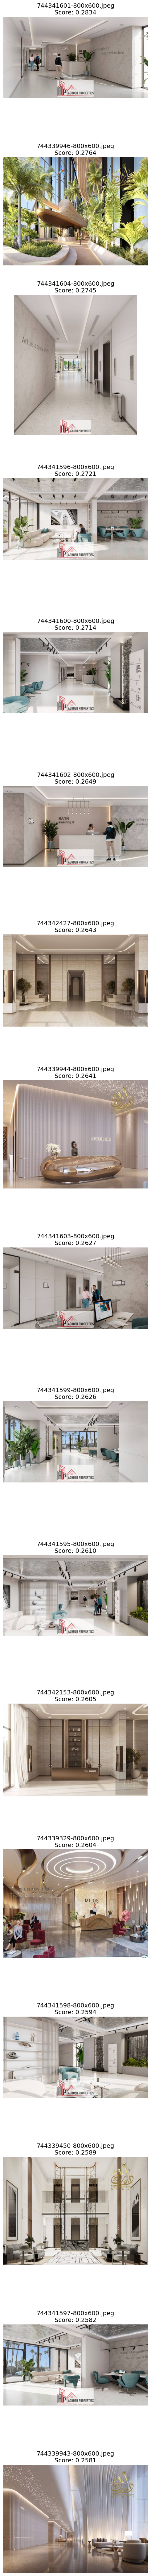

In [ ]:
model_path = '/content/drive/My Drive/Image_text models/CLIP_fine-tunned_freeze_2layer/'

import torch
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
import matplotlib.pyplot as plt
import os
from loguru import logger
import time

# Load Fine-Tuned Model and Processor
start_time = time.time()

print(model_path)
model = CLIPModel.from_pretrained(model_path)
processor = CLIPProcessor.from_pretrained(model_path)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time taken to load the model for the first time: {elapsed_time} seconds")

# Function to Compute Similarity Scores with Score Drop Filtering
def get_similar_images(query, image_dir, threshold=4):
    """
    Args:
        query (str): The text query to search for.
        image_dir (str): Directory containing the images.
        threshold (float): The percentage drop threshold between consecutive scores.

    Returns:
        List of tuples (image_name, score) and a list of corresponding images.
    """
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Prepare the text input
    text_inputs = processor(text=[query], return_tensors="pt", padding=True)
    text_inputs = {k: v.to(device) for k, v in text_inputs.items()}

    # Get text embedding
    with torch.no_grad():
        text_features = model.get_text_features(**text_inputs)
        text_features /= text_features.norm(dim=-1, keepdim=True)  # Normalize

    # Compute similarity scores for all images
    image_scores = []
    images = {}
    fix_threshold = 0.23

    for image_name in os.listdir(image_dir):
        if image_name.endswith(".json"):
            continue
        image_path = os.path.join(image_dir, image_name)
        image = Image.open(image_path).convert("RGB")

        # Process the image
        image_inputs = processor(images=image, return_tensors="pt")
        image_inputs = {k: v.to(device) for k, v in image_inputs.items()}

        # Get image embedding
        with torch.no_grad():
            image_features = model.get_image_features(**image_inputs)
            image_features /= image_features.norm(dim=-1, keepdim=True)  # Normalize

        # Compute cosine similarity
        similarity = torch.matmul(text_features, image_features.T).item()
        image_scores.append((image_name, similarity))
        images[image_name] = image

    # Sort by similarity score in descending order
    image_scores = sorted(image_scores, key=lambda x: x[1], reverse=True)

    # Select images based on score drop
    selected_scores = [image_scores[0]]  # Always include the first image
    for i in range(1, len(image_scores)):
        prev_score = image_scores[i - 1][1]
        curr_score = image_scores[i][1]
        percentage_drop = (prev_score - curr_score) / prev_score
        percentage_drop = percentage_drop * 100

        if percentage_drop > threshold:
            logger.info(f"Exited at id: {i+1} on percentage Drop: {percentage_drop :.2f}% > {threshold :.2f}% on id {i+1}")
            break
        elif curr_score > 0.22:
            selected_scores.append(image_scores[i])


    if image_scores[0][1] < fix_threshold:
        logger.info("All the images are bellow threshold")
        selected_scores = []

    # Get the corresponding images
    selected_images = [images[image_name] for image_name, _ in selected_scores]

    return selected_scores, selected_images

# Display Results
def display_results(query, top_scores, top_images):
    """
    Displays the images with their similarity scores.

    Args:
        query (str): The text query.
        top_scores (list): List of tuples (image_name, score).
        top_images (list): List of PIL images.
    """
    if not top_images:
        print("No images found.")
        return

    print(f"Query: {query}")
    for i, (image_name, score) in enumerate(top_scores):
        print(f"{i+1}: {image_name} (Score: {score:.4f})")

    # Show images vertically with larger scales
    fig, axes = plt.subplots(len(top_images), 1, figsize=(5, 5 * len(top_images)))
    if len(top_images) == 1:
        axes = [axes]  # Ensure axes is iterable for a single image
    for ax, (image, (image_name, score)) in zip(axes, zip(top_images, top_scores)):
        ax.imshow(image)
        ax.set_title(f"{image_name}\nScore: {score:.4f}", fontsize=14)
        ax.axis("off")
    plt.tight_layout()
    plt.show()

# Example Usage
query = "lobby"
image_dir = image_path  # Change to your image directory

start_time = time.time()

top_scores, top_images = get_similar_images(query, image_dir, threshold=3)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time taken to retrive the queryo on {len(os.listdir(image_dir))} images: {elapsed_time} seconds")

display_results(query, top_scores, top_images)


In [ ]:
model_path = '/content/drive/My Drive/Image_text models/CLIP_fine-tunned_freeze_10layer/'

import torch
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
import matplotlib.pyplot as plt
import os
from loguru import logger
import time

# Load Fine-Tuned Model and Processor
start_time = time.time()

print(model_path)
model = CLIPModel.from_pretrained(model_path)
processor = CLIPProcessor.from_pretrained(model_path)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time taken to load the model for the first time: {elapsed_time} seconds")

# Function to Compute Similarity Scores with Score Drop Filtering
def get_similar_images(query, image_dir, threshold=4):
    """
    Args:
        query (str): The text query to search for.
        image_dir (str): Directory containing the images.
        threshold (float): The percentage drop threshold between consecutive scores.

    Returns:
        List of tuples (image_name, score) and a list of corresponding images.
    """
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Prepare the text input
    text_inputs = processor(text=[query], return_tensors="pt", padding=True)
    text_inputs = {k: v.to(device) for k, v in text_inputs.items()}

    # Get text embedding
    with torch.no_grad():
        text_features = model.get_text_features(**text_inputs)
        text_features /= text_features.norm(dim=-1, keepdim=True)  # Normalize

    # Compute similarity scores for all images
    image_scores = []
    images = {}
    fix_threshold = 0.23

    for image_name in os.listdir(image_dir):
        if image_name.endswith(".json"):
            continue
        image_path = os.path.join(image_dir, image_name)
        image = Image.open(image_path).convert("RGB")

        # Process the image
        image_inputs = processor(images=image, return_tensors="pt")
        image_inputs = {k: v.to(device) for k, v in image_inputs.items()}

        # Get image embedding
        with torch.no_grad():
            image_features = model.get_image_features(**image_inputs)
            image_features /= image_features.norm(dim=-1, keepdim=True)  # Normalize

        # Compute cosine similarity
        similarity = torch.matmul(text_features, image_features.T).item()
        image_scores.append((image_name, similarity))
        images[image_name] = image

    # Sort by similarity score in descending order
    image_scores = sorted(image_scores, key=lambda x: x[1], reverse=True)

    # Select images based on score drop
    selected_scores = [image_scores[0]]  # Always include the first image
    for i in range(1, len(image_scores)):
        prev_score = image_scores[i - 1][1]
        curr_score = image_scores[i][1]
        percentage_drop = (prev_score - curr_score) / prev_score
        percentage_drop = percentage_drop * 100

        if percentage_drop > threshold:
            logger.info(f"Exited at id: {i+1} on percentage Drop: {percentage_drop :.2f}% > {threshold :.2f}% on id {i+1}")
            break
        elif curr_score > 0.22:
            selected_scores.append(image_scores[i])


    if image_scores[0][1] < fix_threshold:
        logger.info("All the images are bellow threshold")
        selected_scores = []

    # Get the corresponding images
    selected_images = [images[image_name] for image_name, _ in selected_scores]

    return selected_scores, selected_images

# Display Results
def display_results(query, top_scores, top_images):
    """
    Displays the images with their similarity scores.

    Args:
        query (str): The text query.
        top_scores (list): List of tuples (image_name, score).
        top_images (list): List of PIL images.
    """
    if not top_images:
        print("No images found.")
        return

    print(f"Query: {query}")
    for i, (image_name, score) in enumerate(top_scores):
        print(f"{i+1}: {image_name} (Score: {score:.4f})")

    # Show images vertically with larger scales
    fig, axes = plt.subplots(len(top_images), 1, figsize=(5, 5 * len(top_images)))
    if len(top_images) == 1:
        axes = [axes]  # Ensure axes is iterable for a single image
    for ax, (image, (image_name, score)) in zip(axes, zip(top_images, top_scores)):
        ax.imshow(image)
        ax.set_title(f"{image_name}\nScore: {score:.4f}", fontsize=14)
        ax.axis("off")
    plt.tight_layout()
    plt.show()

# Example Usage
query = "bedroom"
image_dir = image_path  # Change to your image directory

start_time = time.time()

top_scores, top_images = get_similar_images(query, image_dir, threshold=3)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time taken to retrive the queryo on {len(os.listdir(image_dir))} images: {elapsed_time} seconds")

display_results(query, top_scores, top_images)


In [ ]:
model_path = '/content/drive/My Drive/Image_text models/CLIP_fine-tunned_NCEloss/'

import torch
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
import matplotlib.pyplot as plt
import os
from loguru import logger
import time

# Load Fine-Tuned Model and Processor
start_time = time.time()

print(model_path)
model = CLIPModel.from_pretrained(model_path)
processor = CLIPProcessor.from_pretrained(model_path)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time taken to load the model for the first time: {elapsed_time} seconds")

# Function to Compute Similarity Scores with Score Drop Filtering
def get_similar_images(query, image_dir, threshold=4):
    """
    Args:
        query (str): The text query to search for.
        image_dir (str): Directory containing the images.
        threshold (float): The percentage drop threshold between consecutive scores.

    Returns:
        List of tuples (image_name, score) and a list of corresponding images.
    """
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Prepare the text input
    text_inputs = processor(text=[query], return_tensors="pt", padding=True)
    text_inputs = {k: v.to(device) for k, v in text_inputs.items()}

    # Get text embedding
    with torch.no_grad():
        text_features = model.get_text_features(**text_inputs)
        text_features /= text_features.norm(dim=-1, keepdim=True)  # Normalize

    # Compute similarity scores for all images
    image_scores = []
    images = {}
    fix_threshold = 0.23

    for image_name in os.listdir(image_dir):
        if image_name.endswith(".json"):
            continue
        image_path = os.path.join(image_dir, image_name)
        image = Image.open(image_path).convert("RGB")

        # Process the image
        image_inputs = processor(images=image, return_tensors="pt")
        image_inputs = {k: v.to(device) for k, v in image_inputs.items()}

        # Get image embedding
        with torch.no_grad():
            image_features = model.get_image_features(**image_inputs)
            image_features /= image_features.norm(dim=-1, keepdim=True)  # Normalize

        # Compute cosine similarity
        similarity = torch.matmul(text_features, image_features.T).item()
        image_scores.append((image_name, similarity))
        images[image_name] = image

    # Sort by similarity score in descending order
    image_scores = sorted(image_scores, key=lambda x: x[1], reverse=True)

    # Select images based on score drop
    selected_scores = [image_scores[0]]  # Always include the first image
    for i in range(1, len(image_scores)):
        prev_score = image_scores[i - 1][1]
        curr_score = image_scores[i][1]
        percentage_drop = (prev_score - curr_score) / prev_score
        percentage_drop = percentage_drop * 100

        if percentage_drop > threshold:
            logger.info(f"Exited at id: {i+1} on percentage Drop: {percentage_drop :.2f}% > {threshold :.2f}% on id {i+1}")
            break
        elif curr_score > 0.22:
            selected_scores.append(image_scores[i])


    if image_scores[0][1] < fix_threshold:
        logger.info("All the images are bellow threshold")
        selected_scores = []

    # Get the corresponding images
    selected_images = [images[image_name] for image_name, _ in selected_scores]

    return selected_scores, selected_images

# Display Results
def display_results(query, top_scores, top_images):
    """
    Displays the images with their similarity scores.

    Args:
        query (str): The text query.
        top_scores (list): List of tuples (image_name, score).
        top_images (list): List of PIL images.
    """
    if not top_images:
        print("No images found.")
        return

    print(f"Query: {query}")
    for i, (image_name, score) in enumerate(top_scores):
        print(f"{i+1}: {image_name} (Score: {score:.4f})")

    # Show images vertically with larger scales
    fig, axes = plt.subplots(len(top_images), 1, figsize=(5, 5 * len(top_images)))
    if len(top_images) == 1:
        axes = [axes]  # Ensure axes is iterable for a single image
    for ax, (image, (image_name, score)) in zip(axes, zip(top_images, top_scores)):
        ax.imshow(image)
        ax.set_title(f"{image_name}\nScore: {score:.4f}", fontsize=14)
        ax.axis("off")
    plt.tight_layout()
    plt.show()

# Example Usage
query = "view"
image_dir = image_path  # Change to your image directory

start_time = time.time()

top_scores, top_images = get_similar_images(query, image_dir, threshold=3)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time taken to retrive the queryo on {len(os.listdir(image_dir))} images: {elapsed_time} seconds")

display_results(query, top_scores, top_images)


In [ ]:
model_path = '/content/drive/My Drive/Image_text models/CLIP_fine-tunned_batch2/'

import torch
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
import matplotlib.pyplot as plt
import os
from loguru import logger
import time

# Load Fine-Tuned Model and Processor
start_time = time.time()

print(model_path)
model = CLIPModel.from_pretrained(model_path)
processor = CLIPProcessor.from_pretrained(model_path)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time taken to load the model for the first time: {elapsed_time} seconds")

# Function to Compute Similarity Scores with Score Drop Filtering
def get_similar_images(query, image_dir, threshold=4):
    """
    Args:
        query (str): The text query to search for.
        image_dir (str): Directory containing the images.
        threshold (float): The percentage drop threshold between consecutive scores.

    Returns:
        List of tuples (image_name, score) and a list of corresponding images.
    """
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Prepare the text input
    text_inputs = processor(text=[query], return_tensors="pt", padding=True)
    text_inputs = {k: v.to(device) for k, v in text_inputs.items()}

    # Get text embedding
    with torch.no_grad():
        text_features = model.get_text_features(**text_inputs)
        text_features /= text_features.norm(dim=-1, keepdim=True)  # Normalize

    # Compute similarity scores for all images
    image_scores = []
    images = {}
    fix_threshold = 0.23

    for image_name in os.listdir(image_dir):
        if image_name.endswith(".json"):
            continue
        image_path = os.path.join(image_dir, image_name)
        image = Image.open(image_path).convert("RGB")

        # Process the image
        image_inputs = processor(images=image, return_tensors="pt")
        image_inputs = {k: v.to(device) for k, v in image_inputs.items()}

        # Get image embedding
        with torch.no_grad():
            image_features = model.get_image_features(**image_inputs)
            image_features /= image_features.norm(dim=-1, keepdim=True)  # Normalize

        # Compute cosine similarity
        similarity = torch.matmul(text_features, image_features.T).item()
        image_scores.append((image_name, similarity))
        images[image_name] = image

    # Sort by similarity score in descending order
    image_scores = sorted(image_scores, key=lambda x: x[1], reverse=True)

    # Select images based on score drop
    selected_scores = [image_scores[0]]  # Always include the first image
    for i in range(1, len(image_scores)):
        prev_score = image_scores[i - 1][1]
        curr_score = image_scores[i][1]
        percentage_drop = (prev_score - curr_score) / prev_score
        percentage_drop = percentage_drop * 100

        if percentage_drop > threshold:
            logger.info(f"Exited at id: {i+1} on percentage Drop: {percentage_drop :.2f}% > {threshold :.2f}% on id {i+1}")
            break
        elif curr_score > 0.22:
            selected_scores.append(image_scores[i])


    if image_scores[0][1] < fix_threshold:
        logger.info("All the images are bellow threshold")
        selected_scores = []

    # Get the corresponding images
    selected_images = [images[image_name] for image_name, _ in selected_scores]

    return selected_scores, selected_images

# Display Results
def display_results(query, top_scores, top_images):
    """
    Displays the images with their similarity scores.

    Args:
        query (str): The text query.
        top_scores (list): List of tuples (image_name, score).
        top_images (list): List of PIL images.
    """
    if not top_images:
        print("No images found.")
        return

    print(f"Query: {query}")
    for i, (image_name, score) in enumerate(top_scores):
        print(f"{i+1}: {image_name} (Score: {score:.4f})")

    # Show images vertically with larger scales
    fig, axes = plt.subplots(len(top_images), 1, figsize=(5, 5 * len(top_images)))
    if len(top_images) == 1:
        axes = [axes]  # Ensure axes is iterable for a single image
    for ax, (image, (image_name, score)) in zip(axes, zip(top_images, top_scores)):
        ax.imshow(image)
        ax.set_title(f"{image_name}\nScore: {score:.4f}", fontsize=14)
        ax.axis("off")
    plt.tight_layout()
    plt.show()

# Example Usage
query = "bedroom"
image_dir = image_path  # Change to your image directory

start_time = time.time()

top_scores, top_images = get_similar_images(query, image_dir, threshold=4)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time taken to retrive the queryo on {len(os.listdir(image_dir))} images: {elapsed_time} seconds")

display_results(query, top_scores, top_images)


In [ ]:
model_path = '/content/drive/My Drive/Image_text models/CLIP_fine-tunned_batch16/'

import torch
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
import matplotlib.pyplot as plt
import os
from loguru import logger
import time

# Load Fine-Tuned Model and Processor
start_time = time.time()

print(model_path)
model = CLIPModel.from_pretrained(model_path)
processor = CLIPProcessor.from_pretrained(model_path)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time taken to load the model for the first time: {elapsed_time} seconds")

# Function to Compute Similarity Scores with Score Drop Filtering
def get_similar_images(query, image_dir, threshold=4):
    """
    Args:
        query (str): The text query to search for.
        image_dir (str): Directory containing the images.
        threshold (float): The percentage drop threshold between consecutive scores.

    Returns:
        List of tuples (image_name, score) and a list of corresponding images.
    """
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Prepare the text input
    text_inputs = processor(text=[query], return_tensors="pt", padding=True)
    text_inputs = {k: v.to(device) for k, v in text_inputs.items()}

    # Get text embedding
    with torch.no_grad():
        text_features = model.get_text_features(**text_inputs)
        text_features /= text_features.norm(dim=-1, keepdim=True)  # Normalize

    # Compute similarity scores for all images
    image_scores = []
    images = {}
    fix_threshold = 0.23

    for image_name in os.listdir(image_dir):
        if image_name.endswith(".json"):
            continue
        image_path = os.path.join(image_dir, image_name)
        image = Image.open(image_path).convert("RGB")

        # Process the image
        image_inputs = processor(images=image, return_tensors="pt")
        image_inputs = {k: v.to(device) for k, v in image_inputs.items()}

        # Get image embedding
        with torch.no_grad():
            image_features = model.get_image_features(**image_inputs)
            image_features /= image_features.norm(dim=-1, keepdim=True)  # Normalize

        # Compute cosine similarity
        similarity = torch.matmul(text_features, image_features.T).item()
        image_scores.append((image_name, similarity))
        images[image_name] = image

    # Sort by similarity score in descending order
    image_scores = sorted(image_scores, key=lambda x: x[1], reverse=True)

    # Select images based on score drop
    selected_scores = [image_scores[0]]  # Always include the first image
    for i in range(1, len(image_scores)):
        prev_score = image_scores[i - 1][1]
        curr_score = image_scores[i][1]
        percentage_drop = (prev_score - curr_score) / prev_score
        percentage_drop = percentage_drop * 100

        if percentage_drop > threshold:
            logger.info(f"Exited at id: {i+1} on percentage Drop: {percentage_drop :.2f}% > {threshold :.2f}% on id {i+1}")
            break
        elif curr_score > 0.22:
            selected_scores.append(image_scores[i])


    if image_scores[0][1] < fix_threshold:
        logger.info("All the images are bellow threshold")
        selected_scores = []

    # Get the corresponding images
    selected_images = [images[image_name] for image_name, _ in selected_scores]

    return selected_scores, selected_images

# Display Results
def display_results(query, top_scores, top_images):
    """
    Displays the images with their similarity scores.

    Args:
        query (str): The text query.
        top_scores (list): List of tuples (image_name, score).
        top_images (list): List of PIL images.
    """
    if not top_images:
        print("No images found.")
        return

    print(f"Query: {query}")
    for i, (image_name, score) in enumerate(top_scores):
        print(f"{i+1}: {image_name} (Score: {score:.4f})")

    # Show images vertically with larger scales
    fig, axes = plt.subplots(len(top_images), 1, figsize=(5, 5 * len(top_images)))
    if len(top_images) == 1:
        axes = [axes]  # Ensure axes is iterable for a single image
    for ax, (image, (image_name, score)) in zip(axes, zip(top_images, top_scores)):
        ax.imshow(image)
        ax.set_title(f"{image_name}\nScore: {score:.4f}", fontsize=14)
        ax.axis("off")
    plt.tight_layout()
    plt.show()

# Example Usage
query = "kitchen"
image_dir = image_path  # Change to your image directory

start_time = time.time()

top_scores, top_images = get_similar_images(query, image_dir, threshold=4)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time taken to retrive the queryo on {len(os.listdir(image_dir))} images: {elapsed_time} seconds")

display_results(query, top_scores, top_images)


In [ ]:
model_path = '/content/drive/My Drive/Image_text models/CLIP_fine-tunned_test/'

import torch
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
import matplotlib.pyplot as plt
import os
from loguru import logger
import time

# Load Fine-Tuned Model and Processor
start_time = time.time()

print(model_path)
model = CLIPModel.from_pretrained(model_path)
processor = CLIPProcessor.from_pretrained(model_path)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time taken to load the model for the first time: {elapsed_time} seconds")

# Function to Compute Similarity Scores with Score Drop Filtering
def get_similar_images(query, image_dir, threshold=4):
    """
    Args:
        query (str): The text query to search for.
        image_dir (str): Directory containing the images.
        threshold (float): The percentage drop threshold between consecutive scores.

    Returns:
        List of tuples (image_name, score) and a list of corresponding images.
    """
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Prepare the text input
    text_inputs = processor(text=[query], return_tensors="pt", padding=True)
    text_inputs = {k: v.to(device) for k, v in text_inputs.items()}

    # Get text embedding
    with torch.no_grad():
        text_features = model.get_text_features(**text_inputs)
        text_features /= text_features.norm(dim=-1, keepdim=True)  # Normalize

    # Compute similarity scores for all images
    image_scores = []
    images = {}
    fix_threshold = 0.23

    for image_name in os.listdir(image_dir):
        if image_name.endswith(".json"):
            continue
        image_path = os.path.join(image_dir, image_name)
        image = Image.open(image_path).convert("RGB")

        # Process the image
        image_inputs = processor(images=image, return_tensors="pt")
        image_inputs = {k: v.to(device) for k, v in image_inputs.items()}

        # Get image embedding
        with torch.no_grad():
            image_features = model.get_image_features(**image_inputs)
            image_features /= image_features.norm(dim=-1, keepdim=True)  # Normalize

        # Compute cosine similarity
        similarity = torch.matmul(text_features, image_features.T).item()
        image_scores.append((image_name, similarity))
        images[image_name] = image

    # Sort by similarity score in descending order
    image_scores = sorted(image_scores, key=lambda x: x[1], reverse=True)

    # Select images based on score drop
    selected_scores = [image_scores[0]]  # Always include the first image
    for i in range(1, len(image_scores)):
        prev_score = image_scores[i - 1][1]
        curr_score = image_scores[i][1]
        percentage_drop = (prev_score - curr_score) / prev_score
        percentage_drop = percentage_drop * 100

        if percentage_drop > threshold:
            logger.info(f"Exited at id: {i+1} on percentage Drop: {percentage_drop :.2f}% > {threshold :.2f}% on id {i+1}")
            break
        elif curr_score > 0.22:
            selected_scores.append(image_scores[i])


    if image_scores[0][1] < fix_threshold:
        logger.info("All the images are bellow threshold")
        selected_scores = []

    # Get the corresponding images
    selected_images = [images[image_name] for image_name, _ in selected_scores]

    return selected_scores, selected_images

# Display Results
def display_results(query, top_scores, top_images):
    """
    Displays the images with their similarity scores.

    Args:
        query (str): The text query.
        top_scores (list): List of tuples (image_name, score).
        top_images (list): List of PIL images.
    """
    if not top_images:
        print("No images found.")
        return

    print(f"Query: {query}")
    for i, (image_name, score) in enumerate(top_scores):
        print(f"{i+1}: {image_name} (Score: {score:.4f})")

    # Show images vertically with larger scales
    fig, axes = plt.subplots(len(top_images), 1, figsize=(5, 5 * len(top_images)))
    if len(top_images) == 1:
        axes = [axes]  # Ensure axes is iterable for a single image
    for ax, (image, (image_name, score)) in zip(axes, zip(top_images, top_scores)):
        ax.imshow(image)
        ax.set_title(f"{image_name}\nScore: {score:.4f}", fontsize=14)
        ax.axis("off")
    plt.tight_layout()
    plt.show()

# Example Usage
query = "sofa"
image_dir = image_path  # Change to your image directory

start_time = time.time()

top_scores, top_images = get_similar_images(query, image_dir, threshold=4)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time taken to retrive the queryo on {len(os.listdir(image_dir))} images: {elapsed_time} seconds")

display_results(query, top_scores, top_images)


In [ ]:
import os
import torch
import faiss
import numpy as np
from PIL import Image
from transformers import AlignProcessor, AlignModel

def prepare_align():
    processor = AlignProcessor.from_pretrained("kakaobrain/align-base")
    model = AlignModel.from_pretrained("kakaobrain/align-base")
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    model.eval()  # Set model to evaluation mode
    return model, processor, device

# Preprocess and encode images
def preprocess_align(image_dir, processor, model, device):
    if not isinstance(image_dir, str):
        raise ValueError("image_dir should be a string representing a valid directory path.")
    image_embeddings = []
    image_paths = []

    for filename in os.listdir(image_dir):
        if filename.lower().endswith((".jpg", ".jpeg", ".png")):
            image_path = os.path.join(image_dir, filename)
            try:
                image = Image.open(image_path).convert("RGB")
            except Exception as e:
                print(f"Error loading image {image_path}: {e}")
                continue
            inputs = processor(images=image, return_tensors="pt").to(device)

            with torch.no_grad():
                outputs = model.get_image_features(**inputs)

            embedding = outputs.cpu().numpy()
            image_embeddings.append(embedding)
            image_paths.append(image_path)

    if not image_embeddings:
        raise ValueError("No valid images found in the provided directory.")

    # Convert image embeddings to a NumPy array
    image_embeddings = np.vstack(image_embeddings).astype(np.float32)

    # Verify normalization
    norms = np.linalg.norm(image_embeddings, axis=1)
    if not np.allclose(norms, 1.0, atol=1e-3):
        print("Warning: Image embeddings are not properly normalized. Normalizing now.")
        faiss.normalize_L2(image_embeddings)

    return image_embeddings, image_paths

def embed_align(image_embeddings):
    # Normalize embeddings for FAISS (if not already normalized)
    faiss.normalize_L2(image_embeddings)

    # Create FAISS index for Inner Product (Cosine Similarity)
    dimension = image_embeddings.shape[1]
    index = faiss.IndexFlatIP(dimension)
    index.add(image_embeddings)

    return index

# Define search function
def search_align(query, index, model, processor, image_paths, device, top_k=5):
    # Tokenize and encode the query text
    inputs = processor(text=[query], return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model.get_text_features(**inputs)
    text_embedding = outputs.cpu().numpy().astype(np.float32)

    # Normalize query embedding
    faiss.normalize_L2(text_embedding)

    # Perform the search
    D, I = index.search(text_embedding, top_k)

    # Optionally, adjust the similarity scores by scaling
    # For example, multiplying by a scaling factor
    scaling_factor = 1.0  # Adjust as needed
    D_scaled = D * scaling_factor

    # You can also dynamically set the threshold based on distribution
    # For example, threshold = mean + 2 * std
    mean_score = D.mean()
    std_score = D.std()
    threshold = 0.1175
    # Alternatively, set a fixed threshold
    print(f"Mean Score: {mean_score}")
    print(f"Standard Deviation: {std_score}")
    print(f"Threshold: {threshold}")

    results = []
    for idx, i in enumerate(I[0]):
        score = D_scaled[0][idx]
        if score >= threshold:
            results.append((image_paths[i], score))

    # If you prefer to return all results sorted by score, uncomment below
    # results = sorted([(image_paths[i], D_scaled[0][idx]) for idx, i in enumerate(I[0])], key=lambda x: x[1], reverse=True)

    return results

In [ ]:
query = "table"

model_align, processor_align, device = prepare_align()
image_embeddings_align, image_paths_align = preprocess_align(
        image_dir=image_dir,
        processor=processor_align,
        model=model_align,
        device=device
    )
index_align = embed_align(image_embeddings_align)
results_align = search_align(
    query=query,
    index=index_align,
    model=model_align,
    processor=processor_align,
    image_paths=image_paths_align,
    device=device,
    top_k=10
)

Score: 0.1375


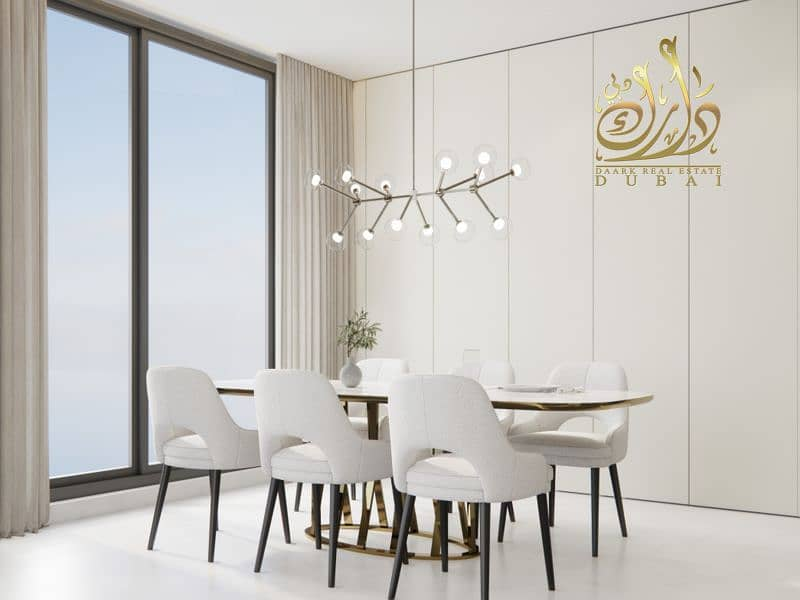

Score: 0.1269


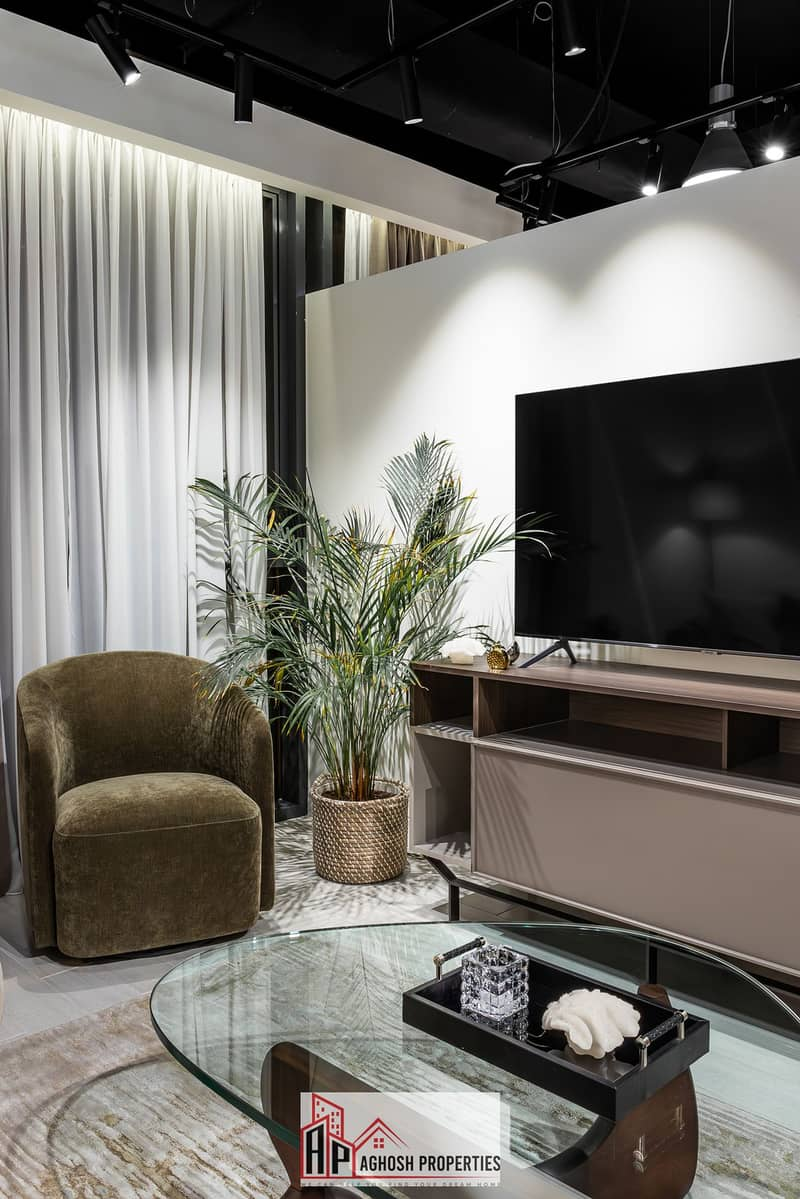

Score: 0.1155


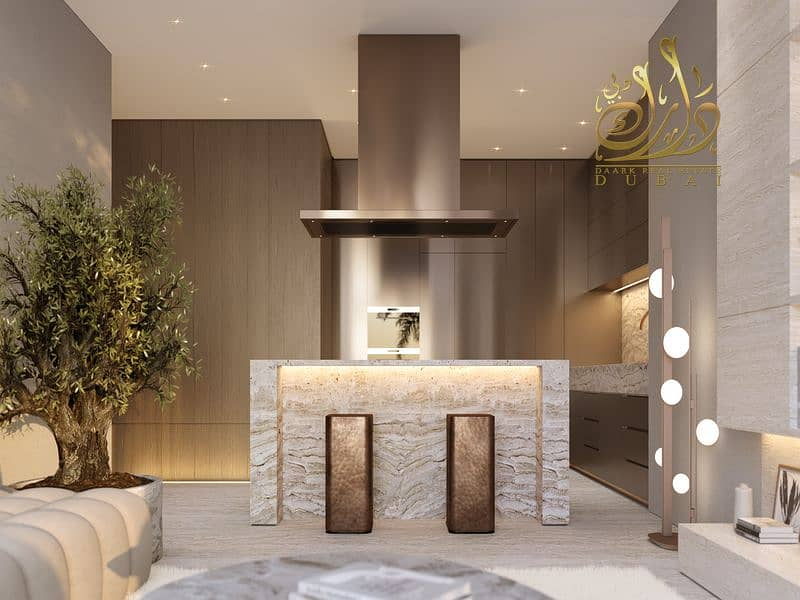

Score: 0.1150


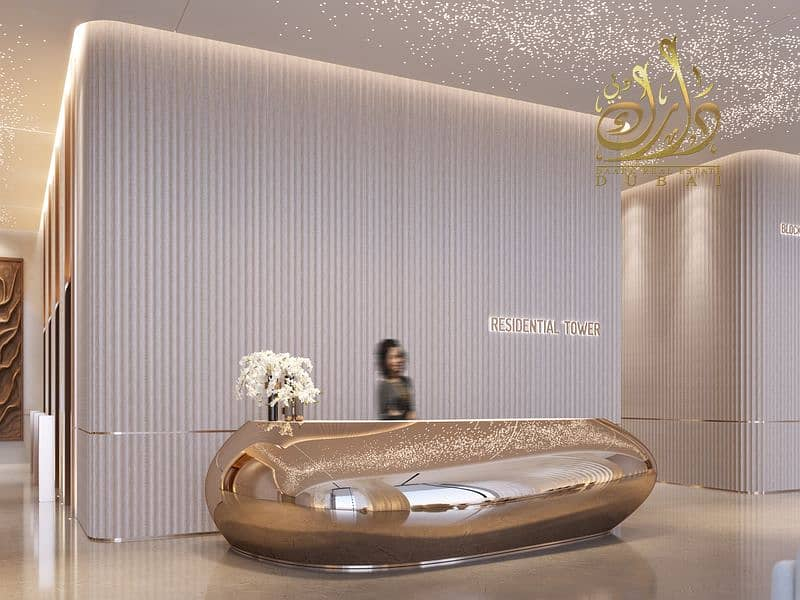

Score: 0.1126


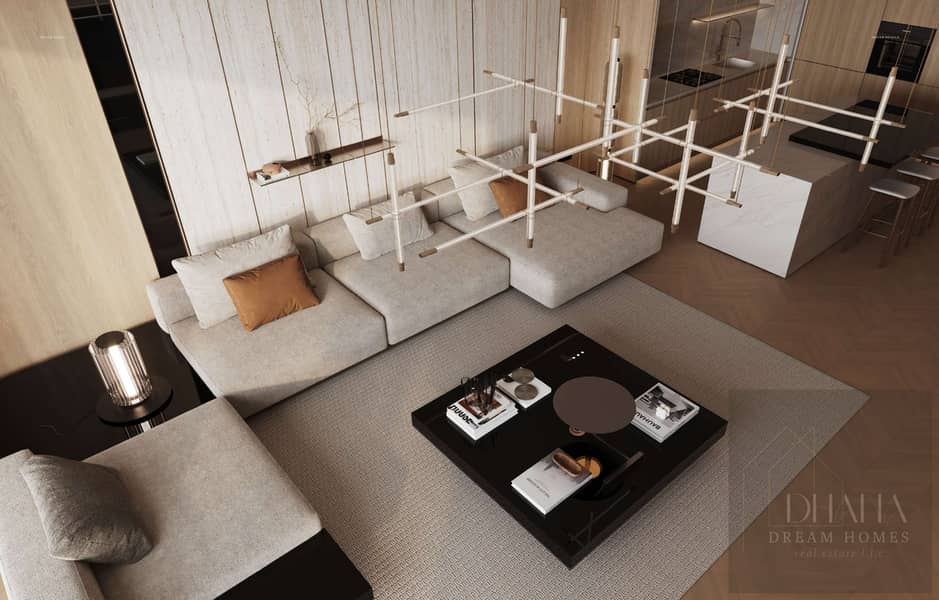

Score: 0.1110


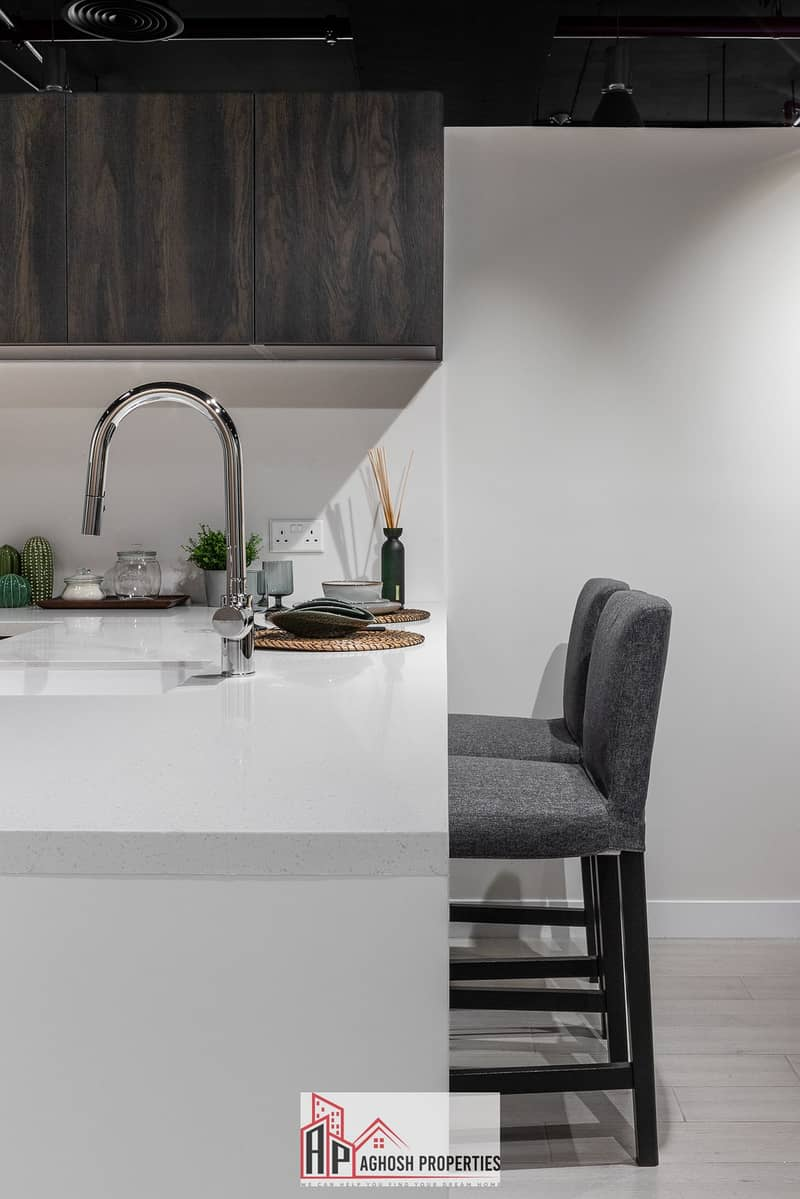

In [ ]:
from IPython.display import Image as IPythonImage, display

if not results_align:
    print("No results found above the threshold.")
else:
    for img_path, score in results_align:
        print(f"Score: {score:.4f}")
        display(IPythonImage(filename=img_path))